<a href="https://colab.research.google.com/github/nyunu/HandsOnMachineLearning/blob/main/3%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3. 분류**

## **3.1 MNIST**

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

**mnist 데이터 구조** <br>
  * descr : 데이터 설명 <br>
  * data : 샘플이 하나의 팽, 특성이 하나의 열로 구성된 배열
  * target : 레이블 배열

In [ ]:
X, y = mnist['data'], mnist['target'] 
X.shape 
# 70000개의 이미지, 28*28 픽셀

(70000, 784)

In [ ]:
y.shape

(70000,)

* 원래 교재 내 코드에서는 some_digit = X[0] 으로 표기되어 있지만, <br>
교재 내 코드대로 실행하면 오류 발생 <br>
* 따라서, 먼저 0번째 샘플의 특성 벡터를 .iloc를 활용해 추출한다 <br>
이후 reshape 함수의 활용이 가능하기 위해서는 some_digit이 array 형태여야 하기 때문에 <br>
np.array를 활용하여 형태를 변환시켜준다. <br>

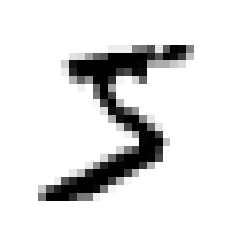

In [ ]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np

some_digit = np.array(X.iloc[0,]) # 샘플의 특성 벡터 추출

some_digit_image = some_digit.reshape(28, 28) # 28*28 배열로 크기 변환

plt.imshow(some_digit_image, cmap='binary') # 흑백 이미지로 보여주기
plt.axis("off")
plt.show()

In [ ]:
y[0]

'5'

In [ ]:
# y를 정수로 변환
y = y.astype(np.uint8)

In [ ]:
# MNIST는 이미 훈련/테스트 데이터를 나눠두었기 때문에 이렇게 진행 (60000이 기준)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## **3.2 이진 분류기 훈련**

* 이진 분류기 : YES OR NO (두개의 클래스로 구분)

In [ ]:
# 5를 기준으로 분류작업을 시행하기 전 타겟 벡터를 생성
y_train_5 = (y_train == 5) # 5이면 True, 5 아니면 다 False
y_test_5 = (y_test == 5)

* **확률적 경사 하강법 (SGD) 분류기**
  - 매우 큰 데이터셋을 효율적으로 처리하는 장점
  - 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문
  - 훈련에 무작위성을 사용 (randome_state =)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## **3.3 성능 측정**

### **3.3.1 교차 검증을 사용한 정확도 측정**

* 교차검증기능 직접 구현 (StratifiedKFold)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)

# 3개의 폴드 대상 계층적 샘플링 실행
# 1,2,3의 폴드로 나누었을 때 1,2,3 각각 한번씩 test로 작용함
# 따라서 총 세번의 반복이 이루어짐
# 1이 테스트일때에는 2,3이 트레인 이런식 !

# X_train, y_train_5를 기준 train 데이터의 인덱스, test 데이터의 인덱스를 이용해 데이터 분리
for train_index, test_index in skfolds.split(X_train, y_train_5):
  # 모델 복제
  clone_clf = clone(sgd_clf)
  # X_train[train_index] -> X_train.iloc[train_index,] 수정
  X_train_folds = X_train.iloc[train_index,]
  y_train_folds = y_train_5[train_index]
  # X_train[test_index] -> X_train.iloc[test_index,] 수정
  X_test_folds = X_train.iloc[test_index,]
  y_test_folds = y_train_5[test_index]

  # 학습 및 예측
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_folds)
  n_correct = sum(y_pred == y_test_folds)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [ ]:
# 데이터 인덱스 형태
skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)

i = 1

for train_index, test_index in skfolds.split(X_train, y_train_5):
  print("'",i,"'")
  print(train_index)
  print(test_index)
  i+=1

' 1 '
[    1     3     4 ... 59994 59996 59998]
[    0     2     6 ... 59995 59997 59999]
' 2 '
[    0     2     3 ... 59997 59998 59999]
[    1    10    11 ... 59988 59989 59991]
' 3 '
[    0     1     2 ... 59995 59997 59999]
[    3     4     5 ... 59994 59996 59998]


* **cross_val_score**
: k-fold 교차검증을 보다 편리하게 할 수 있도록 하는 API
  * cross_val_score(estimator, X, y, cv=교차 검증 폴드 수, scoring=평가지표)
  * estimator가 classifier 종류이면 내부적으로 stratified KFold 로 진행된다는 의미

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

* 모든 이미지를 '5 아님'으로 분류하는 더미 분류기 생성

In [ ]:
from sklearn.base import BaseEstimator

class NeverClassifier(BaseEstimator):
  def fit(self, X, y = None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype = bool)

In [ ]:
never_5_clf = NeverClassifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

이미지의 10% 정도만 숫자 5이기 대문에 무조건 '5아님'으로 분류하면 정확히 맞출 확률이 90%이상 <br>
-> **정확도를 분류기의 성능 측정 지표로 선호하지 않는** 이유 <br>
-> 특히 **불균형한 데이터셋을 다룰 때** 더욱 선호하지 않음

### **3.3.2 오차행렬**

* **오차행렬** : 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것
  * 실제 타깃과 비교할 수 있도록 예측값을 먼저 생성해야 함

* cross_val_predict()
  * k-겹 교차 검증 수행
  * 평가 점수 대신 각 테스트 폴드에서 얻은 예측을 반환
  * 모든 샘플에 대한 예측을 얻을 수 있음

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

* confusion_matrix() -> 오차행렬 생성 <br>

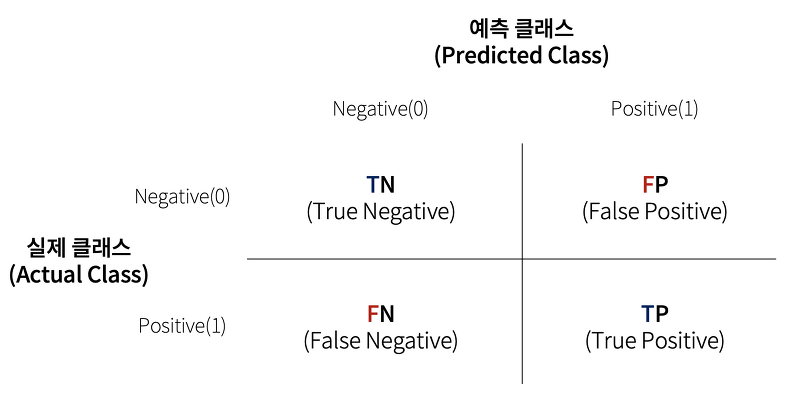 <br>
출처 ) https://velog.io/@sset2323/03-02.-%EC%98%A4%EC%B0%A8-%ED%96%89%EB%A0%AC-Confusion-Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
# 완벽한 분류기일 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**=> 정밀도와 재현율을 함께 사용하는 것이 일반적**

$$
\text{정밀도} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

$$
\text{재현율} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$
<br>



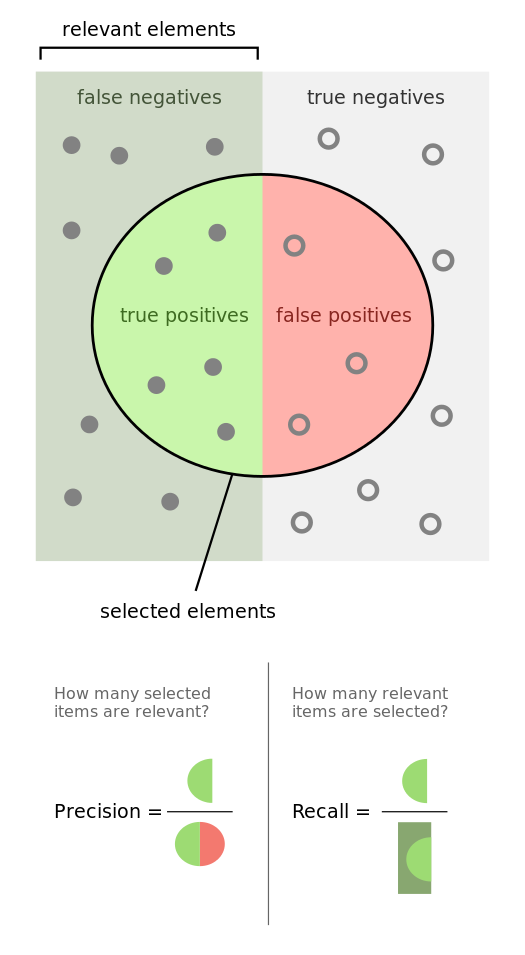 <br>
출처 ) https://m.blog.naver.com/qbxlvnf11/221497600125

### **3.3.3 정밀도와 재현율**

**정밀도&재현율은 트레이드오프 관계**
* **정밀도** : 긍정으로 분류된 것 중에 실제로 긍정인 것
* **재현율** : 실제 긍정인 것 중에 긍정으로 분류된 것

* 정밀도와 재현율 계산

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

* F1-score
  * 정밀도와 재현율을 이용하여 F1-score 생성 <br>
    -> F1-score는 정밀도와 재현율의 조화평균
  * 정밀도와 재현율이 비슷한 분류기에서 높은 값을 지님
  * 상황에 따라 재현율, 정밀도 중 어떤 것이 중요한지가 다르기 때문에 항상 바람직한 것은 아님


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### **3.3.4 정밀도/재현율 트레이드오프**
* 임계값을 올리면 재현율은 낮아지고, 정밀도는 올라감
* 임계값을 내리면 재현율은 높아지고, 정밀도는 내려감 

* decision_function() : 각 샘플의 점수를 얻을 수 있고 이를 기반으로 원하는 임계값을 정해 예측을 만들 수 있음 <br>
  -> 여기서 각 샘플의 점수란 ? <br>
  : 모델이 데이터 포인트가 양성 클래인 클래스 1에 속한다고 믿는 정도 <br>
    훈련 데이터셋의 각 샘플이 테스트 폴드가 되었을 때의 결정 점수

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [ ]:
threshold = 0
# 임계값보다 예측값이 높을 때 True로 분류
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
# 임계값을 올려보았을 때 결과가 달라짐
# 임계값 높이면 재현율이 줄어들게 됨
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

* 적절한 임계값 설정 <br>
  -> 훈련 세트에 있는 모든 샘플의 점수를 계산하여 예측 결과가 아닌 결정 점수를 반환받도록 지정 <br>


In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

* precision_recall_curve() : 모든 임계값에 대해 정밀도와 재현율 계산

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

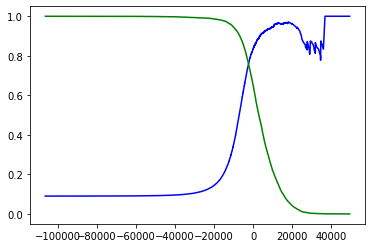

In [ ]:
def plot_precison_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b-", label = "정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label = "재현율")

plot_precison_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

* 정밀도 90%가 목적이라면?<br>
  = 정밀도가 90% 이상이 될 수 있는 임계값을 구하고 그 이상인 값들은 True <br>
  = 모델이 True라고 분류한 것 중에서 실제 True인 것의 비율을 90% 이상이 되도록 한다.<br>
  = y_scores는 데이터가 True로 분류될 것이라 믿는 정도

In [ ]:
# 정밀도가 최소 90%가 되는 임곗값 구하기
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.019499143958

In [ ]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [ ]:
# 위의 임계값보다 큰 값을 가지면 True
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### **3.3.5 ROC 곡선**
1) 민감도(재현율, TPR)에 대한 1-특이도(FPR) 그래프 <br>
2) 이진분류법에서 사용

* TPR (True Positive Rate): 1인 케이스에 대해 1로 바르게 예측하는 비율 (Sensitivity)
* FPR (False positive rate): 0인 케이스에 대해 1로 틀리게 예측하는 비율 (1-Specificity)<br>
  -> TPR과 FPR은 **비례**관계 <br>
  -> TPR과 특이도는 **반비례**관계 (FPR = 1- 특이도 이기 때문) 
<br><br>
* 특이도 (Specificity) <br>
  = 음성으로 정확하게 분류한 음성샘플의 비율 <br>
  = 실제 음성이고 음성으로 분류된 것 / 실제 음성인 것 전부

* roc_curve(): 여러 임계값에서 TPR, FPR을 계산

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

* ROC 곡선이 좌측 상단에 치우쳐 있을수록 좋은 분류기
* ROC 곡선 아래의 면적을 AUC라고 하는데 ROC 곡선이 좌측 상단에 치우쳐 있을수록 그 면적이 더 넓어짐
* AUC가 클수록 더 좋은 분류기

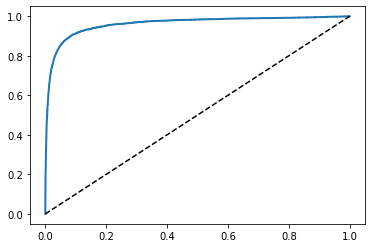

In [ ]:
def plot_roc_curve(fpr, tpr, label = None):
  plt.plot(fpr, tpr, linewidth = 2, label = label)
  plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

* **SGDClassifier VS RandomForestClassifier**

* predict_proba()
  * RandomForestClassifier에 내장된 메서드 (SGD의 decision_function() 대신)
  * 샘플이 행, 클래스가 열 -> 샘플이 주어진 클래스에 속할 확률을 담은 배열 반환

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method  = 'predict_proba')

In [ ]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [ ]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

* 랜덤 포레스트 분류기가 SGD 분류기보다 훨씬 좋다는 결론 (AUC 비교)

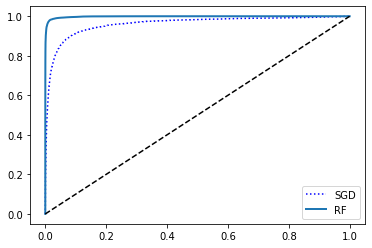

In [ ]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RF")
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## **3.4 다중 분류**
: 둘 이상의 클래스 구별

* 이진 분류기를 여러개 이용해 다중 클래스를 분류하는 기법
  * **OvR [OvA]** : 각 클래스별 이진 분류기를 n개 만들어 훈련시켜서 각 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택
  * **OvO** : 각 클래스의 조합마다의 이진 분류기를 훈련시키는 방식<br>
    - 클래스가 n개일때 분류기는 n(n-1)/2 개가 필요한 셈<br>
    - 각 분류기의 훈련에 전체 훈련 세트 중 두 클래스에 해당하는 샘플만 필요하다는 것이 장점 <br>

  => 대부분은 OvR을 선호 / SVM과 같은 일부 훈련 세트 크기에 민감한 알고리즘은 OvO를 선호

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

* decision_function() : 샘플당 10개의 점수를 반환 (클래스마다 하나씩)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

* 클래스 5에 해당하는 값이 가장 높은 점수

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

* OvO나 OvR을 강제로 사용하도록 설정하는 방법 -> **OneVsOneClassifier** or **OneVsRestClassifier** 사용 <br>
  * 이진 분류기일 필요 없음
  * 이진 분류기 인스턴스를 만들어 객체 생성시에 전달

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

* SGDClassifier 훈련 <br>
  cf) SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 OvR이나 OvO를 적용할 필요 없음

In [ ]:
sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

* 분류기 평가를 위해 교차 검증 사용 (일반적인 절차)

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

* 입력 스케일 조정을 통해 정확도 상승

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

## **3.5 에러 분석**

* 오차 행렬을 분석하여 성능 향상 방안 도출에 사용할 수 있음

* cross_val_predict로 예측을 만든 후 오차행렬 확인

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

* 오차행렬 이미지화
  * 주대각선 : 이미지가 올바르게 분류되었음을 의미
  * 색이 어두울수록 잘 분류되지 못했거나 해당 클래스의 샘플이 적다는 의미 <br>

  => 해당 그래프에서는 숫자 5가 다른 숫자보다 어둡게 나타남

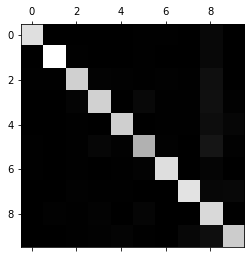

In [ ]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

* 5가 다른 숫자보다 어둡게 나타나는 것이 그래프의 에러라면 <br>
  -> **에러 비율**을 비교 (오차행렬의 각 값 / 대응되는 클래스의 이미지 개수) <br>
  -> **에러의 절대 개수가 아닌 에러 비율임에 주의할 것**

In [69]:
row_sums = conf_mx.sum(axis = 1, keepdims = True) # 실제 클래스 당 이미지 개수
norm_conf_mx = conf_mx / row_sums # 오차행렬의 각 값을 대응되는 클래스의 총 이미지 개수로 나눔
print(row_sums, '\n')
print(norm_conf_mx)

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]] 

[[9.41583657e-01 0.00000000e+00 3.71433395e-03 8.44166807e-04
  1.35066689e-03 7.25983454e-03 6.07800101e-03 1.01300017e-03
  3.79875063e-02 1.68833361e-04]
 [0.00000000e+00 9.49273213e-01 5.48798576e-03 3.55977455e-03
  5.93295758e-04 6.52625334e-03 5.93295758e-04 1.03826758e-03
  3.14446752e-02 1.48323939e-03]
 [4.53172205e-03 4.53172205e-03 8.76132931e-01 1.54414233e-02
  1.22524337e-02 4.53172205e-03 1.12453844e-02 6.04229607e-03
  6.34441088e-02 1.84625713e-03]
 [3.58832164e-03 2.77279400e-03 1.90833469e-02 8.52552602e-01
  3.26211059e-04 3.31104224e-02 4.40384929e-03 6.52422117e-03
  6.57315283e-02 1.19067036e-02]
 [2.05409106e-03 2.39643958e-03 7.01814447e-03 1.54056830e-03
  8.87024991e-01 2.05409106e-03 5.81992468e-03 4.62170490e-03
  5.93974666e-02 2.80725779e-02]
 [4.98063088e-03 2.76701716e-03 5.53403431e-03 3.09905921e-02
  9.77679395e-03 8.19774949e-01 1.38350858e-02 2.58254935e-03
  9.8690

* **행**은 **실제 클래스**를 나타내고, **열**은 **예측한 클래스**를 나타낸다.
  *  8행과 8열을 비교 <br> 
    -> 8열은 상당히 밝아 많은 이미지가 8로 잘못 분류되었음을 확인할 수 있고 & 8행을 보았을 때는 적절히 8로 분류되었음을 확인할 수 있음 <br>
        
  -> **"오차 행렬이 반드시 대칭인 것은 아님"**

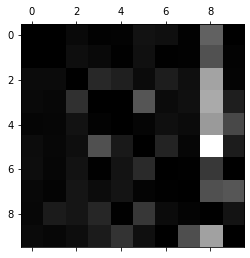

In [ ]:
# 주대각선만 0으로 채워서 그래프 그림
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

* 개개의 에러 분석 ex. 3과 5의 샘플

교재 내 코드를 그대로 적용하면 " 'str' object has no attribute 'reshape' "라는 오류 발생 <br>
따라서 plot_digits 함수 내에 " instances = np.array(instances) "를 추가하여 데이터 프레임을 배열 형태로 변환시켜줌

In [90]:
# 숫자 그림을 위한 추가 함수
import matplotlib as mpl
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    instances = np.array(instances)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [91]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

* 왼쪽 블럭 두 개 : 3으로 분류된 것 / 오른쪽 블럭 두 개 : 5로 분류된 것

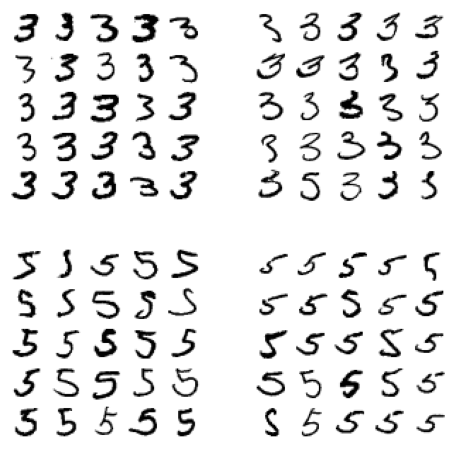

In [92]:
plt.figure(figsize = (8,8))
plt.subplot(221) ; plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222) ; plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223) ; plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224) ; plot_digits(X_bb[:25], images_per_row = 5)
plt.show()

* 잘못 분류된 **원인** ? <br>
: **선형 모델**인 SGD를 사용했기 때문 !<br>

* **선형 모델**이 어때서 ? <br>
  -> 선형 분류기는 **클래스마다 픽셀에 가중치를 할당**하고 새로운 이미지에 대해 **단순히 픽셀 강도의 가중치 합**을 클래스의 점수로 계산 <br>
  -> 3이랑 5는 비슷해서 몇 개의 픽셀만 다르니까 모델이 혼동하기 쉬운 것 !

## **3.6 다중 레이블 분류**
: 분류기가 샘플마다 여러 개의 클래스를 출력

In [99]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # 7보다 크고
y_train_odd = (y_train % 2 == 1) # 홀수
y_multilabel = np.c_[y_train_large, y_train_odd] #각 숫자 이미지에 두 개의 타깃 레이블이 담긴 멀티레이블 / np.c_ : 일차원 배열 붙여서 2차원 배열 만들기
print(y_multilabel, '\n\n', y_train_large, '\n\n', y_train_odd)

[[False  True]
 [False False]
 [False False]
 ...
 [False  True]
 [False False]
 [ True False]] 

 0        False
1        False
2        False
3        False
4         True
         ...  
59995     True
59996    False
59997    False
59998    False
59999     True
Name: class, Length: 60000, dtype: bool 

 0         True
1        False
2        False
3         True
4         True
         ...  
59995    False
59996     True
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool


In [100]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

* some_digit = 5 이므로 7보다 작음 -> False, 홀수 -> True

In [101]:
knn_clf.predict([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

* 다중 레이블 분류기를 평가하는 방법은 많음 
<br> ex. 각 레이블마다의 f1-score을 구하고 평균점수 계산

In [102]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

0.976410265560605

## **3.7 다중 출력 분류**
: 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것

* **이미지 잡음 제거 시스템 생성 예시** 
  * 잡음이 많은 숫자 이미지를 입력
  * 깨끗한 숫자 이미지를 픽셀의 강도를 담은 배열로 출력
  * 이때의 출력은 다중 레이블이며 각 레이블은 다양한 값을 가짐

* randint(): 픽셀 강도에 잡음 추가<br>
  * np.random.randint(시작 숫자, 끝 숫자, 크기) <br>
  * ex. np.random.randint(0, 100, (len(X_train), 784)) <br>
  : 0부터 100 사이의 숫자로 (len(X_train), 784)의 배열 생성

In [105]:
# 잡음을 추가한 데이터(X)를 통해 잡음 없는 데이터(y)를 예측하는 것
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [119]:
def plot_digit(data):
  data = np.array(data)
  image = data.reshape(28, 28)
  plt.imshow(image, cmap = mpl.cm.binary,
              interpolation="nearest")
  plt.axis("off")

* 잡음 추가 이미지 vs 잡음 제거 이미지

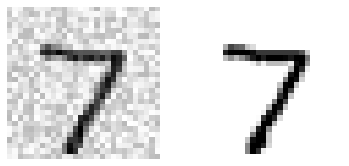

In [122]:
some_index = 0
# 잡음 추가
plt.subplot(121)
plot_digit(X_test_mod.iloc[some_index,:])
# 잡음 제거
plt.subplot(122)
plot_digit(y_test_mod.iloc[some_index,:])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


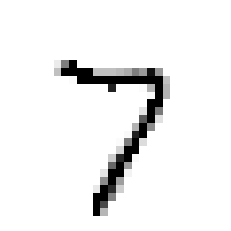

In [124]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index,:]])
plot_digit(clean_digit)